In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [ ]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [ ]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [ ]:
sys.path.append("../DMFiles/")
import particle as pa
from units import *
from constants import *

In [ ]:
sys.path.append("../")
import make_sims

In [ ]:
data_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/fermi_data/"
templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/ps_mask_0.8deg/"

In [ ]:
fermi_data = np.load(data_dir+'fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load(data_dir+'fermidata_exposure.npy')

dif = np.load(data_dir+'template_dif.npy')
iso = np.load(data_dir+'template_iso.npy')
psc = np.load(data_dir+'template_psc.npy')
# psc = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/PS-Maps/ps_map_et3.npy')[ebin]
bub = np.load(data_dir+'template_bub.npy')
dsk = np.load(data_dir+'template_dsk.npy')
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure
nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')*fermi_exposure 
nfw_smoothed = np.load('/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy')[10]*fermi_exposure
ps_mask = np.load(data_dir+'fermidata_pscmask.npy')
ps_mask_0p8 = np.load('/tigress/ljchang/NPTF-IG-Check/data/mask_3fgl_0p8deg.npy')


In [ ]:
best_fit_norms = np.load(templates_dir+"best_fit_norms_band_2_ring_30.npy")
dif_bf = np.load(templates_dir+"dif_band_2_ring_30.npy")
iso_bf = np.load(templates_dir+"iso_band_2_ring_30.npy")
psc_bf = np.load(templates_dir+"psc_band_2_ring_30.npy")
bub_bf = np.load(templates_dir+"bub_band_2_ring_30.npy")
# dsk_bf = np.load(templates_dir+"dsk_band_2_ring_30.npy")

In [ ]:
def dNdF_1break(A,n1,n2,Fb1,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    else:
        return A*(F/Fb1)**(-n2)
    
def dNdF_2break(A,n1,n2,n3,Fb1,Fb2,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    elif F >= Fb2:
        return A*(F/Fb1)**(-n2)
    else:
        return A*(Fb2/Fb1)**(-n2)*(F/Fb2)**(-n3)

In [ ]:
from scipy.stats import chi2

def poiss_err(n,ntrue,alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in 
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3

    :param: alpha corresponds to central confidence level 1-alpha, 
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = chi2.ppf(alpha/2,2*n)/2+ntrue
    sigma_up = chi2.ppf(1-alpha/2,2*(n+1))/2+ntrue

#     sigma = (2*sigma_lo*sigma_up)/(sigma_lo+sigma_up)
#     sigma_prime = (sigma_up-sigma_lo)/(sigma_lo+sigma_up)

    return sigma_lo, sigma_up

In [ ]:
analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=5, mask_ring=True, inner=0, outer=15)

In [ ]:
smoothed_nfw = np.load("/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy")

In [ ]:
Jfac_map_NFW = smoothed_nfw[10]

In [ ]:
ebins = 2*np.logspace(-1,3,41)#[7:39+2]

In [ ]:
sims_dir = "/tigress/ljchang/NPTF-IG-Check/data/simPS/smoothedMaps/"

In [ ]:
f_ary0 = np.logspace(-13,-8,100)

In [ ]:
mask_0p8deg = 1
if mask_0p8deg:
    analysis_mask = analysis_mask_base + ps_mask_0p8
    analysis_mask = analysis_mask > 0 
else:
    analysis_mask = analysis_mask_base + ps_mask
    analysis_mask = analysis_mask > 0 

In [ ]:
hp.mollview(analysis_mask)

In [272]:
area_factor = np.sum(~analysis_mask)/hp.nside2npix(128)
srdeg2_sphere = 4*np.pi*np.rad2deg(1)**2

In [273]:
exposure_map = np.ones(len(fermi_exposure))*np.mean(fermi_exposure)

In [274]:
# exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
# exp_masked_compressed = exp_masked.compressed()
# exp_masked_mean = np.mean(exp_masked_compressed)

exp_masked = ma.masked_array(data=exposure_map, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [275]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2

temp_masked_compressed = ma.masked_array(data=nfw,mask=analysis_mask)
rf = np.sum(temp_masked_compressed/rescale)*exp_masked_mean/area_mask

In [276]:
true_dif, true_iso, true_psc, true_bub, true_gce = np.load("/tigress/ljchang/NPTF-IG-Check/data/baseline_fluxes.npy")

## Make PS map

In [128]:
f_ary0 = np.logspace(-13,-8,500)

In [129]:
SCD_params = np.load("/tigress/ljchang/NPTF-IG-Check/data/kingPSF_NFW_PS_100_GCE_flux_below1ph_flat.npz")["SCD_params"]
SCD = rf*np.array([dNdF_2break(*SCD_params[:4],SCD_params[4]/exp_masked_mean,SCD_params[5]/exp_masked_mean,f) for f in f_ary0])


In [130]:
nside_upgrade = 512
nfw_upgrade = hp.ud_grade(nfw,nside_upgrade,power=-2)
analysis_mask_upgrade = hp.ud_grade(analysis_mask,nside_upgrade,power=-2)

In [131]:
# sim = make_sims.simPS(f_ary=f_ary0,dNdF_ary=SCD,spatial_map=nfw_upgrade,nsources=12500,nside=nside_upgrade,verbose=True)

Generating a map of 12500 point sources with nside = 512


In [27]:
# sim_fluxes = sim.fluxvals
# sim_pixvals = sim.pixvals
# sim_map = hp.ud_grade(sim.flux_map,128,power=-2)*exposure_map

/tigress/ljchang/heptools/anaconda3/envs/venv_NPTF/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


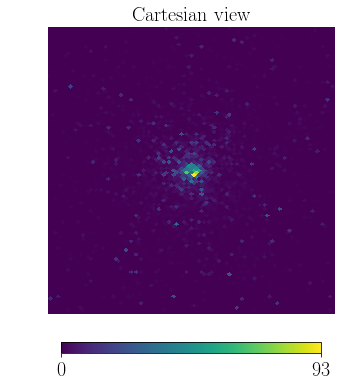

In [28]:
hp.cartview(sim_map,lonra=[-20,20],latra=[-20,20])

In [29]:
fluxes_masked = []
for i in range(len(sim_fluxes)):
    if not analysis_mask_upgrade[sim_pixvals[i]]:
        fluxes_masked.append(sim_fluxes[i])

In [30]:
counts, bin_edges = np.histogram(fluxes_masked,bins=np.logspace(-13,-6,60))
bin_centers = np.sqrt(bin_edges[1:]*bin_edges[:-1])
bin_widths = bin_edges[1:]-bin_edges[:-1]

In [31]:
sim_y_counts = counts/(bin_widths*area_factor*srdeg2_sphere)
sim_err_L = (counts-poiss_err(counts,0)[0])/(bin_widths*area_factor*srdeg2_sphere)
sim_err_H = (poiss_err(counts,0)[1]-counts)/(bin_widths*area_factor*srdeg2_sphere)

In [32]:
sim_map_masked_compressed = ma.masked_array(data=hp.ud_grade(sim_map,128,power=-2), mask=analysis_mask).compressed()
sim_PS_intens = np.mean(sim_map_masked_compressed/exp_masked_compressed/hp.nside2pixarea(128))

In [34]:
sim_PS_intens

5.921580570627741e-08

In [97]:
sim_PS_intens

6.507662020848585e-08

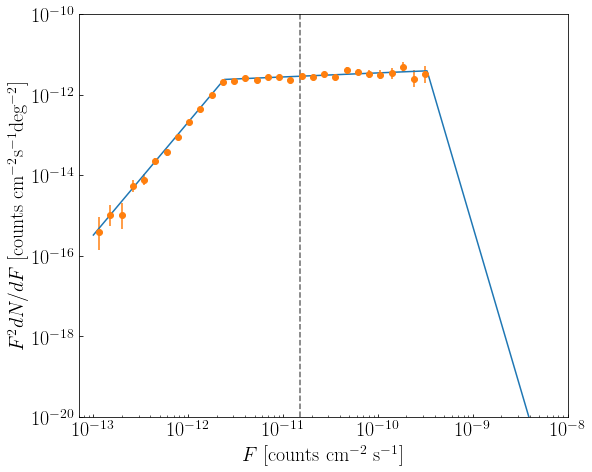

In [73]:
plt.plot(f_ary0,f_ary0**2*SCD)
plt.errorbar(bin_centers,bin_centers**2*sim_y_counts,yerr=bin_centers**2*np.array([sim_err_L,sim_err_H]), fmt='o')

plt.yscale('log')
plt.xscale('log')
plt.xlim(7e-14,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tick_params(which='both',direction='in')
plt.tight_layout()

## Reload smoothed maps

In [277]:
data_tag = "NFW_PS_below1ph_flat_2048"


In [278]:
smoothed_map = np.load(sims_dir+data_tag+"_bin10.npy")

In [279]:
orig_map = np.load("/tigress/ljchang/NPTF-IG-Check/data/simPS/"+data_tag+".npz")['flux_map']

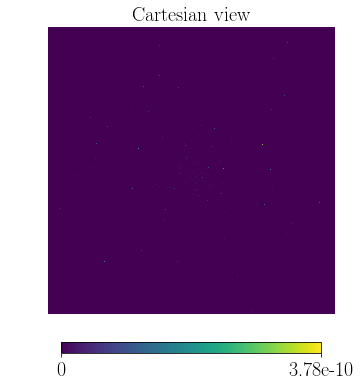

In [280]:
hp.cartview(orig_map,lonra=[-10,10],latra=[-10,10])

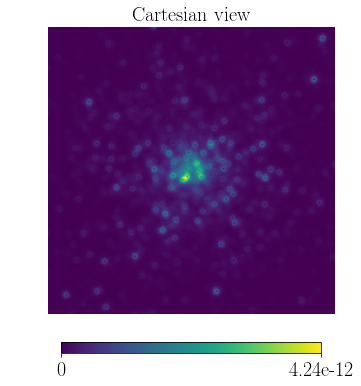

In [281]:
hp.cartview(smoothed_map,lonra=[-10,10],latra=[-10,10])

In [282]:
sim_map_smoothed = hp.ud_grade(smoothed_map,128,power=-2)*exposure_map

In [283]:
dif_bf_newroi = np.load(templates_dir+"dif_band_5_ring_15.npy")
dif_bf_newroi_flat = dif_bf_newroi/rescale

In [284]:
dif_bf_newroi_flat_masked_compressed = ma.masked_array(data=dif_bf_newroi_flat, mask=analysis_mask).compressed()
dif_bf_newroi_flat_intens = np.mean(dif_bf_newroi_flat_masked_compressed/exp_masked_compressed/hp.nside2pixarea(128))

In [285]:
dif_bf_newroi_flat_intens

3.168786784168086e-06

In [286]:
sim_map_unsmoothed = hp.ud_grade(orig_map,128,power=-2)*exposure_map

In [287]:
sim_map_unsmoothed_masked_compressed = ma.masked_array(data=sim_map_unsmoothed, mask=analysis_mask).compressed()
sim_map_unsmoothed_intens = np.mean(sim_map_unsmoothed_masked_compressed/exp_masked_compressed/hp.nside2pixarea(128))


In [288]:
sim_map_unsmoothed_intens

1.2732698357006707e-07

In [289]:
dif_bf_newroi_flat_intens/sim_map_unsmoothed_intens

24.887001131416316

In [295]:
hp.cartview(~analysis_mask*(sim_map_unsmoothed+dif_bf_newroi_flat),lonra=[-50,50],latra=[-50,50])

OSError: [Errno 122] Disk quota exceeded: '/home/ljchang/.cache/matplotlib/tex.cache/fceb133489a9a3ce96021e00fc5a305c.tex'

<Figure size 612x388.8 with 2 Axes>

In [297]:
for MC in range(50):
    np.save("/tigress/ljchang/NPTF-IG-Check/data/simPS/MCs/with_bkg_components/flat_exposure/varyROI/b_5_r_15/"+data_tag+"_dif_MC"+str(MC)+".npy",np.random.poisson(sim_map_unsmoothed+dif_bf_newroi_flat))


In [56]:
# for MC in range(50):
#     np.save("/tigress/ljchang/NPTF-IG-Check/data/simPS/MCs/with_bkg_components/flat_exposure/king_smoothed/"+data_tag+"_dif_MC"+str(MC)+".npy",np.random.poisson(sim_map_smoothed+dif_bf_newroi_flat))
